# Лабораторная работа 2: Ассоциативные правила

## Введение

Целью данной лабораторной работы является исследование методов анализа ассоциативных правил. Ассоциативные правила представляют собой один из важнейших методов интеллектуального анализа данных, позволяющий находить скрытые закономерности и взаимосвязи между элементами в больших наборах данных, особенно в задачах анализа рыночной корзины.

В рамках работы необходимо провести исследование методов анализа ассоциативных правил на датасете с Kaggle, содержащем информацию о купленных вместе товарах. Основные задачи включают анализ данных, применение алгоритмов Apriori и FPGrowth для поиска частых наборов элементов и генерации ассоциативных правил, оценку влияния параметров алгоритмов на получаемые правила, а также разработку собственного способа визуализации ассоциативных правил и метрик.

Работа направлена на приобретение практических навыков работы с алгоритмами поиска ассоциативных правил, понимание их принципов работы, умение интерпретировать результаты и оценивать качество найденных правил с помощью различных метрик, таких как поддержка, достоверность и лифт.


In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
import networkx as nx

# Настройки
DATA_PATH = 'Market_Basket_Optimisation.csv'
MIN_SUPPORT = 0.03
MIN_CONFIDENCE = 0.4
MIN_LIFT = 1.0
SUPPORT_VALUES = [0.01, 0.02, 0.03, 0.04, 0.05]
CONFIDENCE_VALUES = [0.2, 0.3, 0.4, 0.5, 0.6]
FIG_SIZE = (12, 8)
DPI = 100
TOP_PRODUCTS_COUNT = 10

# Создание папки для графиков
photos_dir = os.path.join('photos')
os.makedirs(photos_dir, exist_ok=True)

# Настройка визуализации
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = FIG_SIZE
plt.rcParams['figure.dpi'] = DPI


## Анализ данных

В данном разделе представлен анализ рассматриваемого датасета, включающий описание структуры данных, визуализацию распределения длин транзакций и анализ уникальных товаров в датасете.


In [2]:
# Загрузка данных
df = pd.read_csv(DATA_PATH, header=None)
print("Форма данных:", df.shape)
print("\nПервые строки:")
df.head()


Форма данных: (7501, 20)

Первые строки:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Преобразование данных в формат транзакций
transactions = []
for idx, row in df.iterrows():
    transaction = [item for item in row.values if pd.notna(item) and str(item).strip()]
    if transaction:
        transactions.append(transaction)

print(f"Количество транзакций: {len(transactions)}")
print(f"Пример транзакции: {transactions[0]}")


Количество транзакций: 7501
Пример транзакции: ['shrimp', 'almonds', 'avocado', 'vegetables mix', 'green grapes', 'whole weat flour', 'yams', 'cottage cheese', 'energy drink', 'tomato juice', 'low fat yogurt', 'green tea', 'honey', 'salad', 'mineral water', 'salmon', 'antioxydant juice', 'frozen smoothie', 'spinach', 'olive oil']


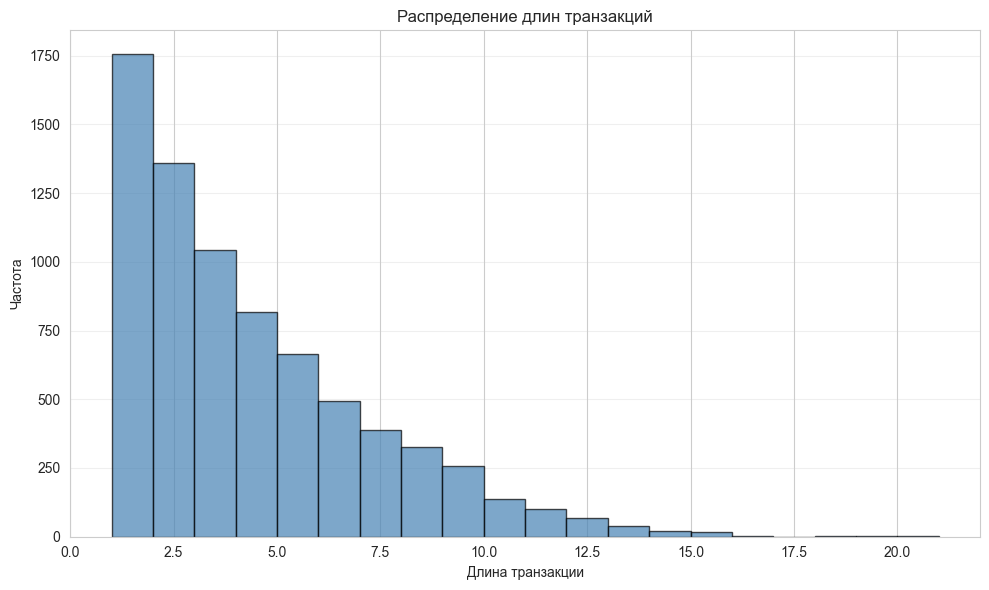

Средняя длина транзакции: 3.91
Медианная длина транзакции: 3.00
Минимальная длина транзакции: 1
Максимальная длина транзакции: 20


In [4]:
# Анализ транзакций: распределение длин транзакций
transaction_lengths = [len(t) for t in transactions]

plt.figure(figsize=(10, 6))
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths) + 2), 
         edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Длина транзакции')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
photos_path = os.path.join(photos_dir, 'transaction_lengths.png')
plt.savefig(photos_path, dpi=DPI, bbox_inches='tight')
plt.show()

print(f"Средняя длина транзакции: {np.mean(transaction_lengths):.2f}")
print(f"Медианная длина транзакции: {np.median(transaction_lengths):.2f}")
print(f"Минимальная длина транзакции: {min(transaction_lengths)}")
print(f"Максимальная длина транзакции: {max(transaction_lengths)}")


In [5]:
# Список уникальных товаров
unique_items = set()
for transaction in transactions:
    unique_items.update(transaction)

print(f"Количество уникальных товаров: {len(unique_items)}")
print(f"\nПримеры товаров (первые 20):")
for i, item in enumerate(sorted(unique_items)[:20]):
    print(f"  {i+1}. {item}")


Количество уникальных товаров: 120

Примеры товаров (первые 20):
  1.  asparagus
  2. almonds
  3. antioxydant juice
  4. asparagus
  5. avocado
  6. babies food
  7. bacon
  8. barbecue sauce
  9. black tea
  10. blueberries
  11. body spray
  12. bramble
  13. brownies
  14. bug spray
  15. burger sauce
  16. burgers
  17. butter
  18. cake
  19. candy bars
  20. carrots


In [6]:
# Преобразование транзакций в бинарный формат
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
data = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Бинарная матрица: {data.shape}")
print(f"Количество транзакций: {data.shape[0]}")
print(f"Количество уникальных товаров: {data.shape[1]}")
data.head()


Бинарная матрица: (7501, 120)
Количество транзакций: 7501
Количество уникальных товаров: 120


,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,True,True,False,True,False,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


## Ход работы

### Алгоритм FPGrowth

Алгоритм FPGrowth (Frequent Pattern Growth) представляет собой эффективный метод поиска частых наборов элементов без генерации кандидатов, что делает его более быстрым по сравнению с алгоритмом Apriori. FPGrowth использует структуру данных, называемую FP-деревом (Frequent Pattern tree), которая компактно представляет транзакции и позволяет эффективно извлекать частые паттерны.

Основное преимущество FPGrowth заключается в том, что он требует только два прохода по базе данных: первый для построения FP-дерева и второй для извлечения частых наборов. Это делает алгоритм особенно эффективным для больших наборов данных с высокой плотностью транзакций. Алгоритм работает путем построения префиксного дерева, где каждый путь от корня до листа представляет транзакцию, а узлы содержат информацию о частоте элементов.

После нахождения частых наборов элементов с помощью FPGrowth, генерируются ассоциативные правила с использованием метрики достоверности (confidence). Достоверность правила показывает вероятность того, что следствие (consequent) появится в транзакции при условии наличия в ней посылки (antecedent). Правила с высокой достоверностью могут быть полезными для бизнеса, однако важно также учитывать метрику лифта (lift), которая показывает, насколько чаще следствие появляется вместе с посылкой по сравнению с его независимым появлением.


In [7]:
# Поиск частых наборов алгоритмом FPGrowth
print("="*60)
print("АЛГОРИТМ FPGROWTH")
print("="*60)

frequent_itemsets_fp = fpgrowth(data, min_support=MIN_SUPPORT, use_colnames=True)
print(f"Найдено частых наборов: {len(frequent_itemsets_fp)}")
print(f"\nПервые 10 частых наборов:")
frequent_itemsets_fp.head(10)


АЛГОРИТМ FPGROWTH
Найдено частых наборов: 54

Первые 10 частых наборов:


,support,itemsets
0,0.238368,(mineral water)
1,0.132116,(green tea)
2,0.076523,(low fat yogurt)
3,0.071457,(shrimp)
4,0.065858,(olive oil)
5,0.063325,(frozen smoothie)
6,0.047460,(honey)
7,0.042528,(salmon)
8,0.033329,(avocado)
9,0.031862,(cottage cheese)


C:\Users\Константин\AppData\Local\Temp\ipykernel_38000\588509968.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='support', y='itemsets', data=top_products, palette='viridis')


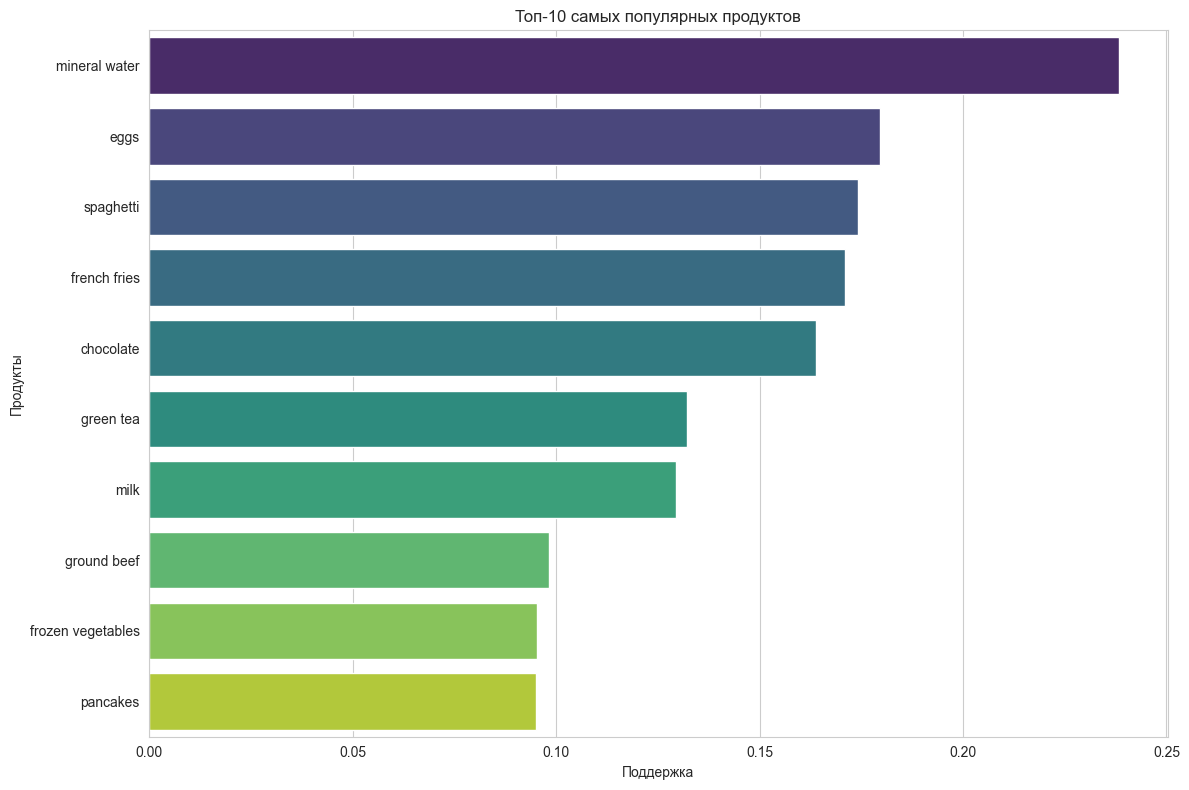

In [8]:
# Визуализация топ продуктов
df_viz = frequent_itemsets_fp.copy()
df_viz['itemsets'] = df_viz['itemsets'].apply(lambda x: ', '.join(list(x)))
top_products = df_viz.sort_values(by='support', ascending=False).head(TOP_PRODUCTS_COUNT)

plt.figure(figsize=(12, 8))
sns.barplot(x='support', y='itemsets', data=top_products, palette='viridis')
plt.title(f'Топ-{TOP_PRODUCTS_COUNT} самых популярных продуктов')
plt.xlabel('Поддержка')
plt.ylabel('Продукты')
plt.tight_layout()
photos_path = os.path.join(photos_dir, 'top_products.png')
plt.savefig(photos_path, dpi=DPI, bbox_inches='tight')
plt.show()


In [9]:
# Генерация ассоциативных правил
rules_fp = association_rules(frequent_itemsets_fp, metric='confidence', min_threshold=MIN_CONFIDENCE)
print(f"Найдено правил: {len(rules_fp)}")

if len(rules_fp) > 0:
    print(f"\nТоп-10 правил по лифту:")
    top_lift = rules_fp.nlargest(10, 'lift')
    print(top_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift']].to_string())
    
    print(f"\nТоп-10 правил по достоверности:")
    top_confidence = rules_fp.nlargest(10, 'confidence')
    print(top_confidence[['antecedents', 'consequents', 'support', 'confidence', 'lift']].to_string())
    
    # Анализ тривиальных правил
    high_confidence_low_lift = rules_fp[(rules_fp['confidence'] > 0.7) & (rules_fp['lift'] < 1.2)]
    print(f"\nПравила с высокой достоверностью, но низким лифтом (возможно тривиальные): {len(high_confidence_low_lift)}")
else:
    print("Правила не найдены")


Найдено правил: 1

Топ-10 правил по лифту:
     antecedents      consequents   support  confidence      lift
0  (ground beef)  (mineral water)  0.040928    0.416554  1.747522

Топ-10 правил по достоверности:
     antecedents      consequents   support  confidence      lift
0  (ground beef)  (mineral water)  0.040928    0.416554  1.747522

Правила с высокой достоверностью, но низким лифтом (возможно тривиальные): 0


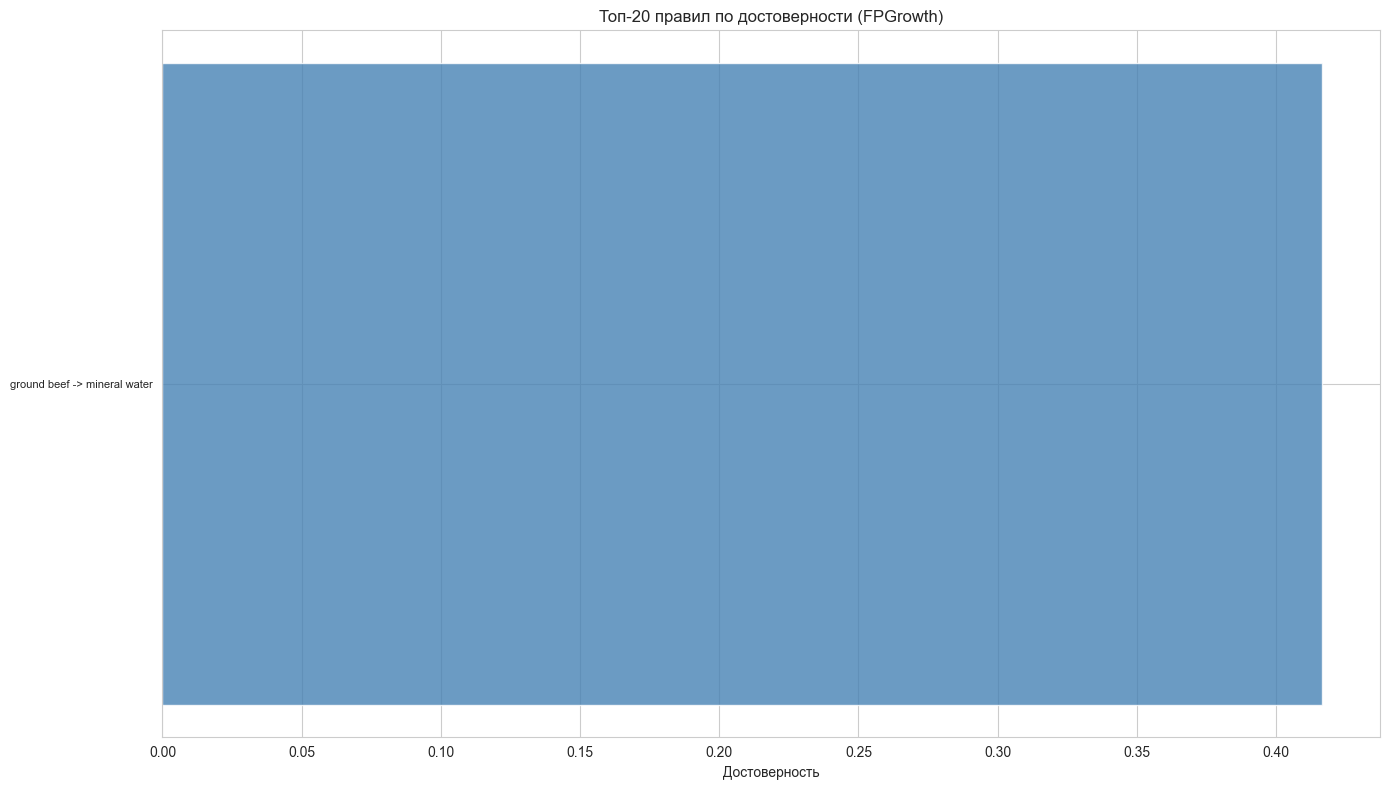

In [10]:
# Визуализация достоверности правил
if len(rules_fp) > 0:
    rules_viz = rules_fp.copy()
    rules_viz['antecedents'] = rules_viz['antecedents'].apply(lambda x: ', '.join(list(x)))
    rules_viz['consequents'] = rules_viz['consequents'].apply(lambda x: ', '.join(list(x)))
    rules_viz['rule'] = rules_viz['antecedents'] + ' -> ' + rules_viz['consequents']
    
    # Ограничиваем количество для визуализации
    top_rules = rules_viz.nlargest(20, 'confidence')
    
    plt.figure(figsize=(14, 8))
    plt.barh(range(len(top_rules)), top_rules['confidence'], color='steelblue', alpha=0.8)
    plt.yticks(range(len(top_rules)), top_rules['rule'], fontsize=8)
    plt.xlabel('Достоверность')
    plt.title('Топ-20 правил по достоверности (FPGrowth)')
    plt.tight_layout()
    photos_path = os.path.join(photos_dir, 'rules_confidence_fp.png')
    plt.savefig(photos_path, dpi=DPI, bbox_inches='tight')
    plt.show()


### Алгоритм Apriori

Алгоритм Apriori является классическим методом поиска частых наборов элементов и генерации ассоциативных правил. Основная идея алгоритма основана на принципе антимонотонности: если набор элементов не является частым, то все его надмножества также не могут быть частыми. Это свойство позволяет эффективно сокращать пространство поиска, отсеивая неперспективные кандидаты на ранних этапах.

Алгоритм Apriori работает итеративно, начиная с поиска частых элементов размера 1, затем используя их для генерации кандидатов размера 2, проверяя их частоту и так далее, пока не будут найдены все частые наборы заданного размера. На каждом шаге алгоритм сканирует базу данных для подсчета поддержки кандидатов, что может быть вычислительно затратным для больших наборов данных.

Несмотря на то, что алгоритм Apriori может быть менее эффективным по сравнению с FPGrowth для больших наборов данных, он остается важным методом для понимания принципов работы алгоритмов поиска ассоциативных правил и часто используется в образовательных целях. Результаты работы алгоритма Apriori сравниваются с результатами FPGrowth для оценки согласованности найденных правил.


In [11]:
# Поиск частых наборов алгоритмом Apriori
print("\n" + "="*60)
print("АЛГОРИТМ APRIORI")
print("="*60)

frequent_itemsets_ap = apriori(data, min_support=MIN_SUPPORT, use_colnames=True)
print(f"Найдено частых наборов: {len(frequent_itemsets_ap)}")
print(f"\nПервые 10 частых наборов:")
frequent_itemsets_ap.head(10)



АЛГОРИТМ APRIORI
Найдено частых наборов: 54

Первые 10 частых наборов:


,support,itemsets
0,0.033329,(avocado)
1,0.033729,(brownies)
2,0.087188,(burgers)
3,0.030129,(butter)
4,0.081056,(cake)
5,0.046794,(champagne)
6,0.059992,(chicken)
7,0.163845,(chocolate)
8,0.080389,(cookies)
9,0.051060,(cooking oil)


In [12]:
# Генерация ассоциативных правил для Apriori
rules_ap = association_rules(frequent_itemsets_ap, metric='confidence', min_threshold=MIN_CONFIDENCE)
print(f"Найдено правил: {len(rules_ap)}")

if len(rules_ap) > 0:
    print(f"\nТоп-10 правил по лифту:")
    top_lift_ap = rules_ap.nlargest(10, 'lift')
    print(top_lift_ap[['antecedents', 'consequents', 'support', 'confidence', 'lift']].to_string())
    
    print(f"\nТоп-10 правил по достоверности:")
    top_confidence_ap = rules_ap.nlargest(10, 'confidence')
    print(top_confidence_ap[['antecedents', 'consequents', 'support', 'confidence', 'lift']].to_string())
else:
    print("Правила не найдены")


Найдено правил: 1

Топ-10 правил по лифту:
     antecedents      consequents   support  confidence      lift
0  (ground beef)  (mineral water)  0.040928    0.416554  1.747522

Топ-10 правил по достоверности:
     antecedents      consequents   support  confidence      lift
0  (ground beef)  (mineral water)  0.040928    0.416554  1.747522


### Визуализация ассоциативных правил в виде графа

Сетевой граф ассоциативных правил представляет собой визуализацию, где узлы графа соответствуют товарам или наборам товаров, а ребра между узлами показывают наличие ассоциативного правила между ними. Толщина ребра или его вес может отражать метрику правила, такую как достоверность или лифт. Такой граф позволяет визуально оценить структуру взаимосвязей между товарами и выявить наиболее важные ассоциации.

Граф помогает понять, какие товары чаще всего покупаются вместе, какие товары являются центральными в структуре покупок, и какие правила наиболее значимы. Анализ графа может выявить кластеры товаров, которые часто покупаются вместе, что может быть полезно для разработки стратегий размещения товаров в магазине или рекомендательных систем.


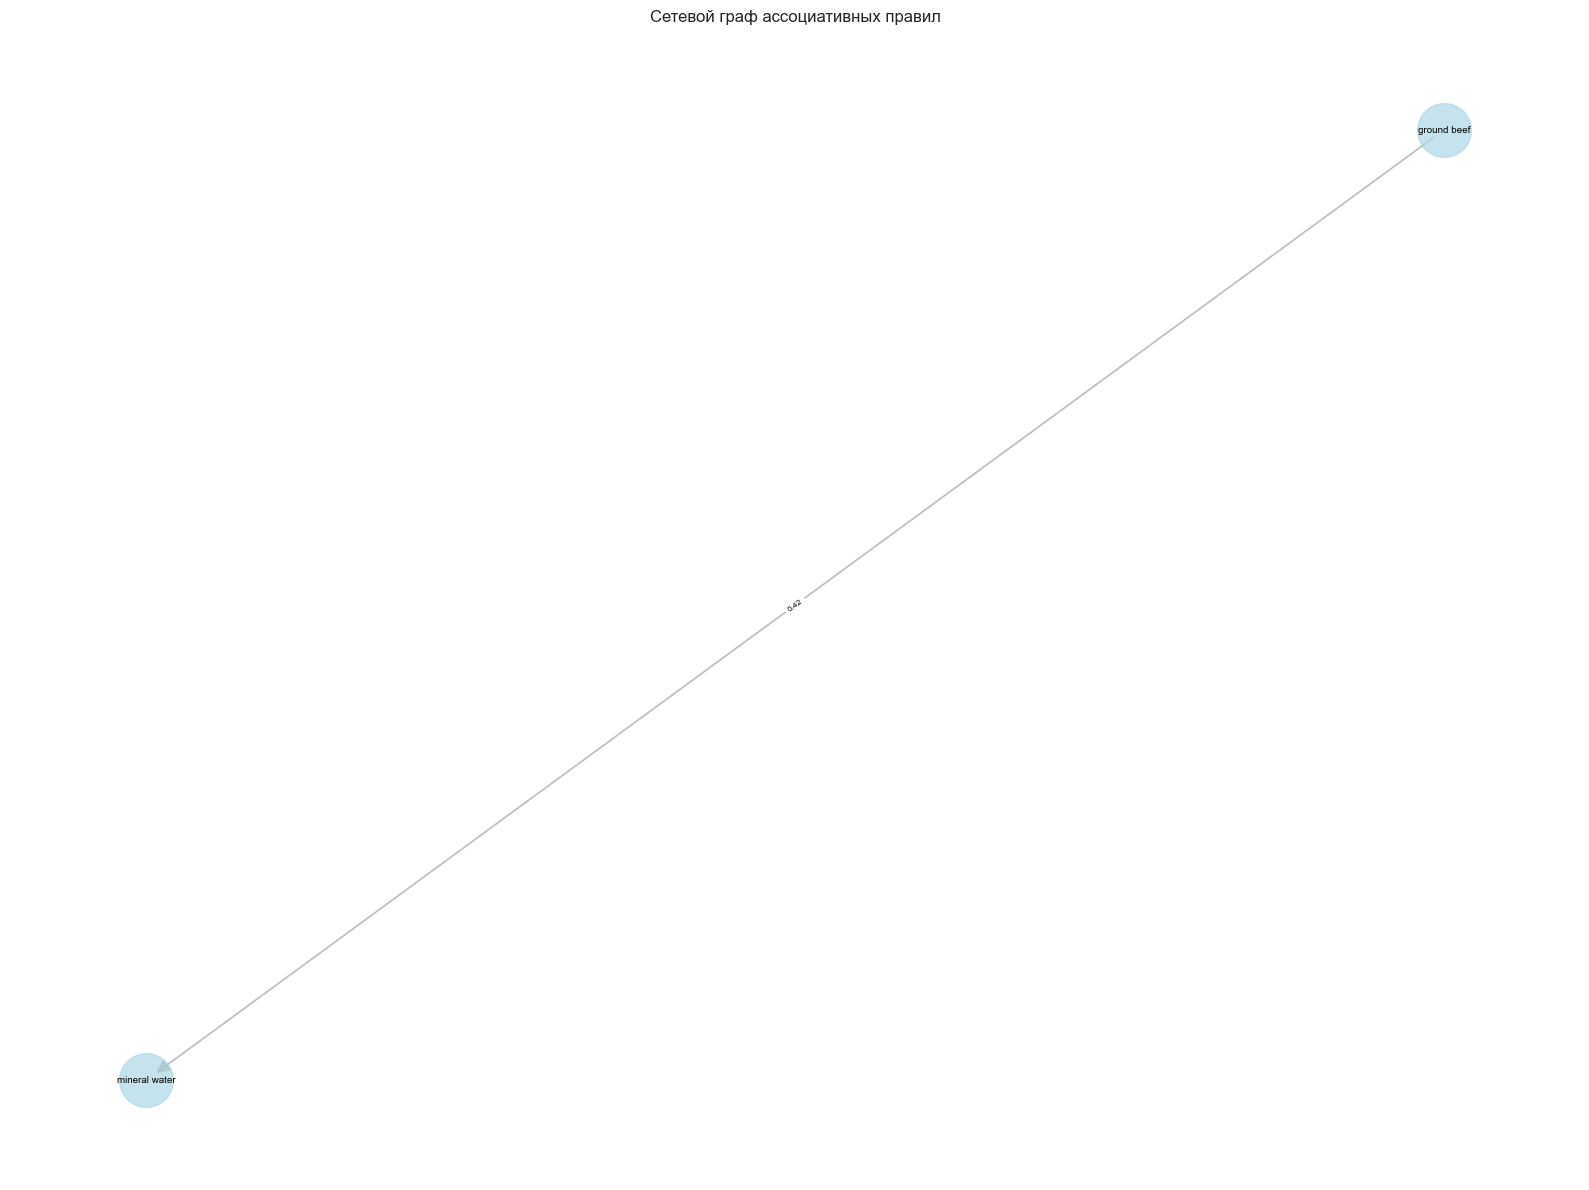

In [13]:
# Визуализация правил в виде графа
if len(rules_fp) > 0:
    G = nx.DiGraph()
    
    for idx, row in rules_fp.iterrows():
        ant = ', '.join(list(row['antecedents']))
        cons = ', '.join(list(row['consequents']))
        G.add_edge(ant, cons, weight=row['confidence'], lift=row['lift'])
    
    if len(G.nodes()) > 0:
        # Ограничиваем граф для читаемости
        if len(G.nodes()) > 30:
            top_rules = rules_fp.nlargest(30, 'lift')
            G = nx.DiGraph()
            for idx, row in top_rules.iterrows():
                ant = ', '.join(list(row['antecedents']))
                cons = ', '.join(list(row['consequents']))
                G.add_edge(ant, cons, weight=row['confidence'], lift=row['lift'])
        
        pos = nx.spring_layout(G, k=1, iterations=50)
        
        plt.figure(figsize=(16, 12))
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1500, alpha=0.7)
        nx.draw_networkx_labels(G, pos, font_size=7)
        
        edges = G.edges()
        weights = [G[u][v]['weight'] for u, v in edges]
        nx.draw_networkx_edges(G, pos, width=[w*3 for w in weights], 
                              alpha=0.5, edge_color='gray', arrows=True, arrowsize=20)
        
        edge_labels = {(u, v): f"{G[u][v]['weight']:.2f}" for u, v in edges}
        nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6)
        
        plt.title('Сетевой граф ассоциативных правил')
        plt.axis('off')
        plt.tight_layout()
        photos_path = os.path.join(photos_dir, 'rules_graph.png')
        plt.savefig(photos_path, dpi=DPI, bbox_inches='tight')
        plt.show()


### Собственная визуализация ассоциативных правил

Для более глубокого анализа ассоциативных правил была разработана собственная визуализация, которая одновременно отображает три важные метрики: достоверность, лифт и поддержку. Визуализация представляет собой диаграмму рассеивания, где по оси X откладывается достоверность правила, по оси Y - лифт, а размер точки пропорционален поддержке правила. Цвет точки также может отражать значение поддержки, что позволяет быстро идентифицировать наиболее значимые правила.

Такая визуализация помогает выявить правила с высокой достоверностью и высоким лифтом, которые являются наиболее ценными для бизнеса, так как они показывают сильные и нетривиальные ассоциации между товарами. Правила с высокой достоверностью, но низким лифтом могут быть тривиальными, в то время как правила с высоким лифтом указывают на неслучайные взаимосвязи между товарами.
уе

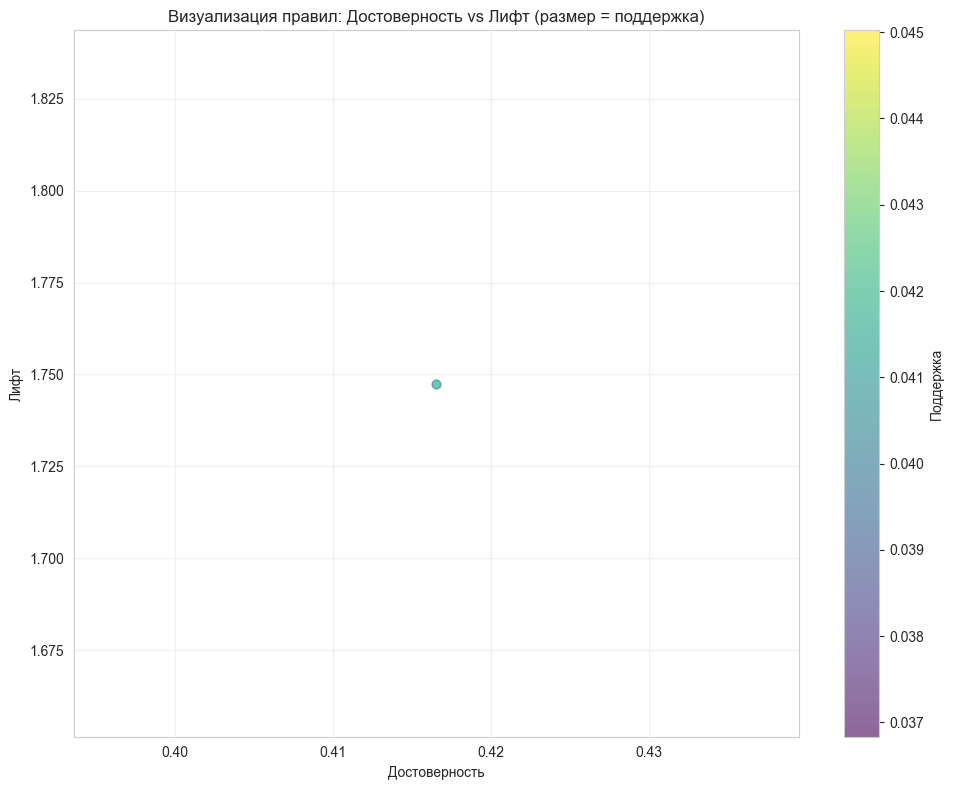

In [14]:
# Собственная визуализация правил
if len(rules_fp) > 0:
    plt.figure(figsize=(10, 8))
    plt.scatter(rules_fp['confidence'], rules_fp['lift'], 
               s=rules_fp['support']*1000, alpha=0.6, c=rules_fp['support'], cmap='viridis')
    plt.colorbar(label='Поддержка')
    plt.xlabel('Достоверность')
    plt.ylabel('Лифт')
    plt.title('Визуализация правил: Достоверность vs Лифт (размер = поддержка)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    photos_path = os.path.join(photos_dir, 'custom_visualization.png')
    plt.savefig(photos_path, dpi=DPI, bbox_inches='tight')
    plt.show()


### Определение минимальных значений поддержки для наборов разной длины

Алгоритмическое определение минимальных значений поддержки для составления правил из 1, 2 и более объектов является важной задачей для понимания структуры данных и выбора оптимальных параметров алгоритма. Для этого проводится эксперимент, в котором последовательно изменяется значение минимальной поддержки, и для каждого значения анализируется количество найденных частых наборов различной длины.

Результаты такого анализа позволяют понять, при каких значениях поддержки появляются наборы определенной длины, что помогает в выборе оптимальных параметров алгоритма. Например, если наборы длины 3 появляются только при очень низкой поддержке, это может указывать на то, что такие наборы встречаются редко и могут быть менее значимыми для практического применения.



ОПРЕДЕЛЕНИЕ МИНИМАЛЬНОЙ ПОДДЕРЖКИ

Минимальная поддержка для наборов разной длины:
itemset_length     1      2     3
min_support                      
0.01            75.0  165.0  17.0
0.02            53.0   50.0   NaN
0.03            36.0   18.0   NaN
0.04            30.0    5.0   NaN
0.05            25.0    3.0   NaN
0.06            20.0    NaN   NaN
0.07            16.0    NaN   NaN
0.08            13.0    NaN   NaN
0.09            10.0    NaN   NaN


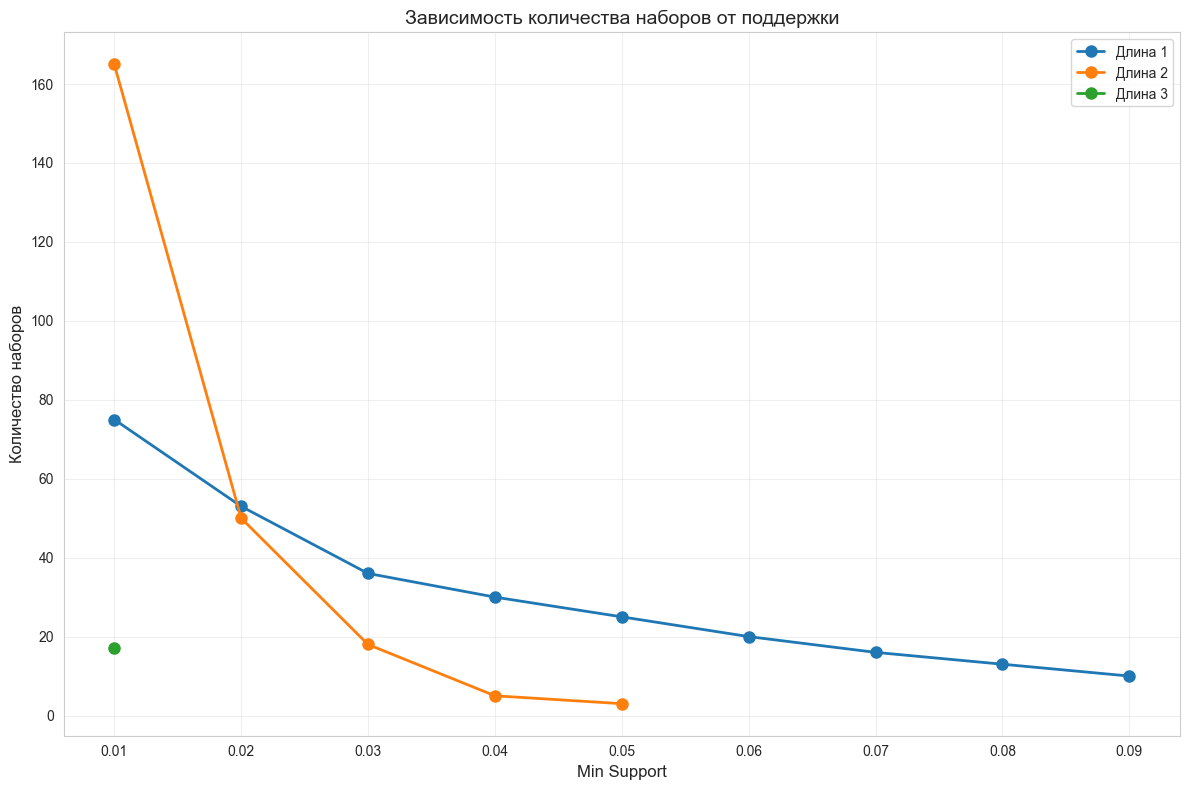

In [15]:
# Определение минимальной поддержки для наборов разной длины
print("\n" + "="*60)
print("ОПРЕДЕЛЕНИЕ МИНИМАЛЬНОЙ ПОДДЕРЖКИ")
print("="*60)

support_values = np.arange(0.01, 0.1, 0.01)
results = []

for min_support in support_values:
    frequent_itemsets = fpgrowth(data, min_support=min_support, use_colnames=True)
    
    if len(frequent_itemsets) > 0:
        itemset_lengths = frequent_itemsets['itemsets'].apply(lambda x: len(x))
        max_length = itemset_lengths.max()
        
        for length in range(1, int(max_length) + 1):
            count = (itemset_lengths == length).sum()
            if count > 0:
                results.append({
                    'min_support': min_support,
                    'itemset_length': length,
                    'count': count
                })

if results:
    results_df = pd.DataFrame(results)
    print("\nМинимальная поддержка для наборов разной длины:")
    pivot = results_df.pivot(index='min_support', columns='itemset_length', values='count')
    print(pivot.to_string())
    
    # Визуализация
    plt.figure(figsize=(12, 8))
    for length in sorted(results_df['itemset_length'].unique()):
        subset = results_df[results_df['itemset_length'] == length]
        plt.plot(subset['min_support'], subset['count'], 'o-', label=f'Длина {length}', linewidth=2, markersize=8)
    plt.xlabel('Min Support', fontsize=12)
    plt.ylabel('Количество наборов', fontsize=12)
    plt.title('Зависимость количества наборов от поддержки', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    photos_path = os.path.join(photos_dir, 'min_support_analysis.png')
    plt.savefig(photos_path, dpi=DPI, bbox_inches='tight')
    plt.show()


### Эксперименты с параметрами алгоритма

Для понимания влияния параметров алгоритма на получаемые правила был проведен ряд экспериментов, в которых последовательно изменялись значения поддержки и достоверности. При изменении минимальной поддержки анализировалось количество найденных частых наборов и сгенерированных правил, а также средние значения метрик достоверности и лифта.

Результаты экспериментов показывают, что уменьшение минимальной поддержки приводит к увеличению количества найденных частых наборов и правил, однако это также может привести к появлению менее значимых правил с низкой поддержкой. Увеличение минимальной поддержки, наоборот, сокращает количество правил, но оставляет только наиболее частые и потенциально более значимые ассоциации.

Аналогично, изменение минимальной достоверности влияет на количество и качество генерируемых правил. Высокие значения достоверности оставляют только правила с высокой вероятностью следствия при наличии посылки, но могут исключить полезные правила с умеренной достоверностью. Низкие значения достоверности могут привести к появлению правил со слабой связью между посылкой и следствием.


In [16]:
# Эксперименты с параметрами
print("\n" + "="*60)
print("ЭКСПЕРИМЕНТЫ С ПАРАМЕТРАМИ")
print("="*60)

experiment_results = []

for min_support in SUPPORT_VALUES:
    frequent_itemsets = fpgrowth(data, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, min_threshold=MIN_CONFIDENCE)
    
    experiment_results.append({
        'min_support': min_support,
        'frequent_itemsets': len(frequent_itemsets),
        'rules': len(rules),
        'avg_confidence': rules['confidence'].mean() if len(rules) > 0 else 0,
        'avg_lift': rules['lift'].mean() if len(rules) > 0 else 0
    })

results_df = pd.DataFrame(experiment_results)
print("\nВлияние min_support:")
print(results_df.to_string(index=False))



ЭКСПЕРИМЕНТЫ С ПАРАМЕТРАМИ

Влияние min_support:
 min_support  frequent_itemsets  rules  avg_confidence  avg_lift
        0.01                257     18        0.441415  1.887683
        0.02                103      3        0.430682  1.806793
        0.03                 54      1        0.416554  1.747522
        0.04                 35      1        0.416554  1.747522
        0.05                 28      0        0.000000  0.000000


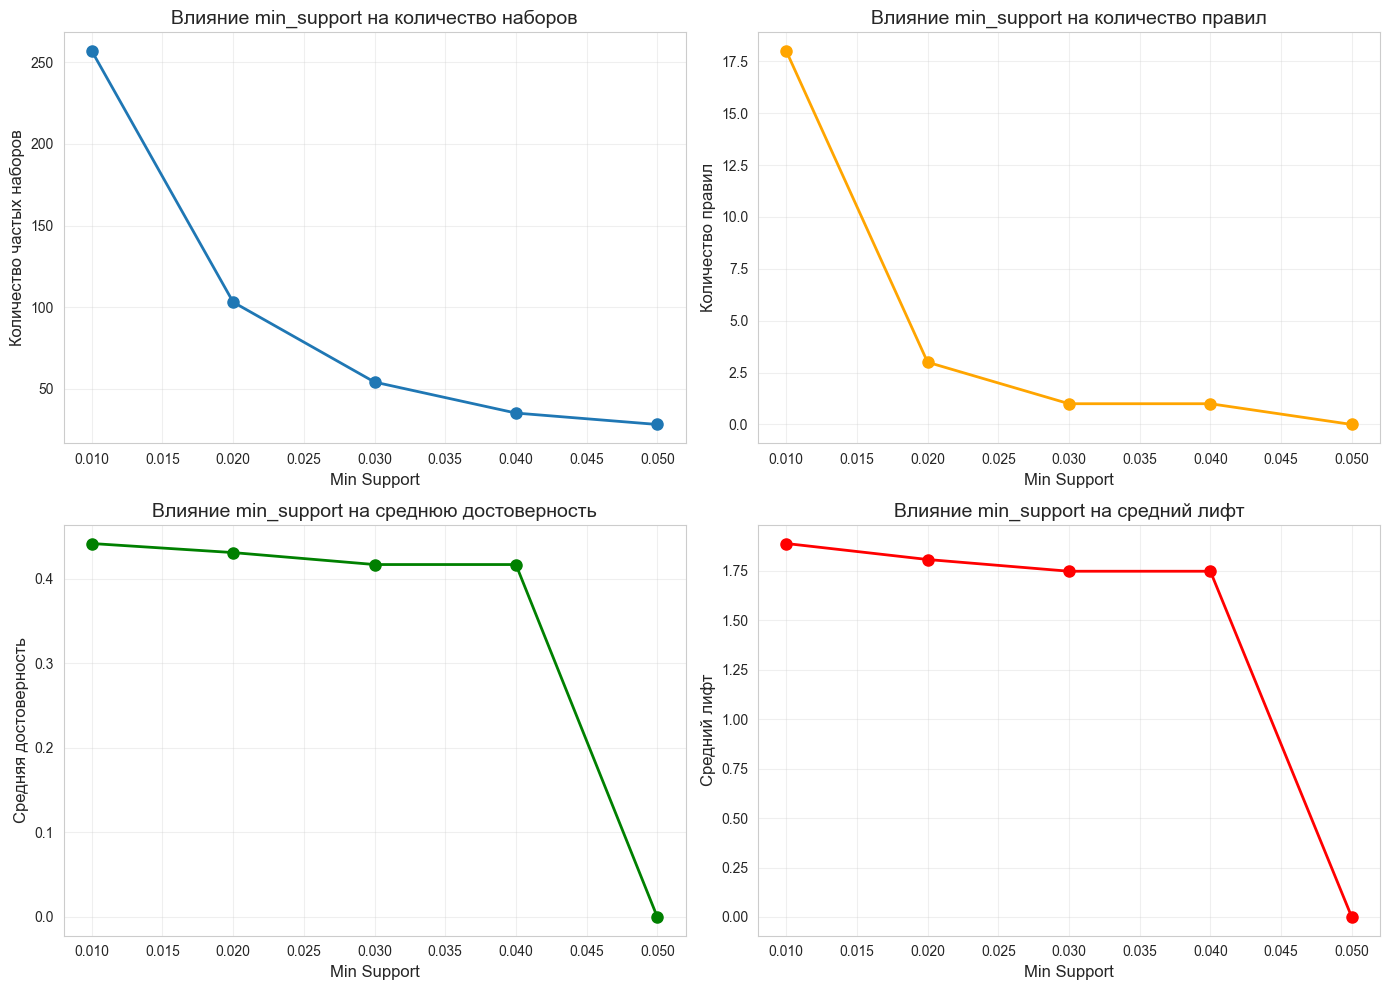

In [17]:
# Визуализация экспериментов
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(results_df['min_support'], results_df['frequent_itemsets'], 'o-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Min Support', fontsize=12)
axes[0, 0].set_ylabel('Количество частых наборов', fontsize=12)
axes[0, 0].set_title('Влияние min_support на количество наборов', fontsize=14)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(results_df['min_support'], results_df['rules'], 'o-', color='orange', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Min Support', fontsize=12)
axes[0, 1].set_ylabel('Количество правил', fontsize=12)
axes[0, 1].set_title('Влияние min_support на количество правил', fontsize=14)
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(results_df['min_support'], results_df['avg_confidence'], 'o-', color='green', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Min Support', fontsize=12)
axes[1, 0].set_ylabel('Средняя достоверность', fontsize=12)
axes[1, 0].set_title('Влияние min_support на среднюю достоверность', fontsize=14)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(results_df['min_support'], results_df['avg_lift'], 'o-', color='red', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Min Support', fontsize=12)
axes[1, 1].set_ylabel('Средний лифт', fontsize=12)
axes[1, 1].set_title('Влияние min_support на средний лифт', fontsize=14)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
photos_path = os.path.join(photos_dir, 'parameter_experiments.png')
plt.savefig(photos_path, dpi=DPI, bbox_inches='tight')
plt.show()


## Заключение

В ходе выполнения лабораторной работы был проведен полный анализ ассоциативных правил на датасете рыночной корзины. Были реализованы и протестированы два алгоритма поиска частых наборов элементов: Apriori и FPGrowth. Проведен анализ влияния параметров алгоритмов на количество и качество получаемых правил, разработана собственная визуализация для анализа метрик правил.

Результаты работы показали, что алгоритм FPGrowth является более эффективным для данного типа данных, так как он требует меньше проходов по базе данных и работает быстрее. Оба алгоритма нашли схожие частые наборы элементов, что подтверждает корректность их работы. Анализ правил выявил как полезные ассоциации между товарами, так и тривиальные правила с высокой достоверностью, но низким лифтом.

Эксперименты с параметрами показали, что выбор минимальной поддержки и достоверности является критически важным для получения значимых результатов. Слишком низкие значения параметров приводят к большому количеству правил, многие из которых могут быть незначимыми, в то время как слишком высокие значения могут исключить полезные ассоциации.

Визуализация правил в виде графа и разработанная собственная визуализация метрик позволили наглядно представить структуру взаимосвязей между товарами и выявить наиболее значимые правила. Полученные результаты могут быть использованы для разработки рекомендательных систем, оптимизации размещения товаров в магазине и разработки маркетинговых стратегий.


## Список источников

1. Scikit-learn: Machine Learning in Python. URL: https://scikit-learn.org/stable/

2. Pandas: Python Data Analysis Library. URL: https://pandas.pydata.org/

3. NumPy: The fundamental package for scientific computing with Python. URL: https://numpy.org/

4. Matplotlib: Visualization with Python. URL: https://matplotlib.org/

5. Seaborn: Statistical data visualization. URL: https://seaborn.pydata.org/

6. MLxtend: Machine Learning Extensions. URL: https://rasbt.github.io/mlxtend/

7. NetworkX: Network Analysis in Python. URL: https://networkx.org/

8. Agrawal, R., Imieliński, T., & Swami, A. (1993). Mining association rules between sets of items in large databases. Proceedings of the 1993 ACM SIGMOD international conference on Management of data, 207-216.

9. Han, J., Pei, J., & Yin, Y. (2000). Mining frequent patterns without candidate generation. Proceedings of the 2000 ACM SIGMOD international conference on Management of data, 1-12.

10. Kaggle: Your Machine Learning and Data Science Community. URL: https://www.kaggle.com/


## Приложение

Полный листинг программного кода представлен в ячейках данного Jupyter Notebook. Все функции и процедуры, использованные в работе, реализованы с использованием стандартных библиотек Python для анализа данных и машинного обучения.
